In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

firstTime = True

raios = [[47.6,48.3],[56.6,57.7],[64,65.7], [59.4,61,2],[69.2,70.6],[76,78.7], [72.4,75.4]]
nomes = ["1 centimo","2 centimos","5 centimos","10 centimos","20 centimos","50 centimos" , "1 euro"]
valores = [1,2,5,10,20,50 ,100]
 

#LEITURA DE IMAGENS

img = cv2.imread("C:/Users/danii/Desktop/Faculdade/3ANO/PIV/TP1_41850_PIV/P1000697s.jpg") # Moedas random
img1 = cv2.imread("C:/Users/danii/Desktop/Faculdade/3ANO/PIV/TP1_41850_PIV/P1000698s.jpg") #Moedas Juntas
img2 = cv2.imread("C:/Users/danii/Desktop/Faculdade/3ANO/PIV/TP1_41850_PIV/P1000699s.jpg") #Moedas Juntas
img3 = cv2.imread("C:/Users/danii/Desktop/Faculdade/3ANO/PIV/TP1_41850_PIV/P1000705s.jpg") #Moedas Juntas
img4 = cv2.imread("C:/Users/danii/Desktop/Faculdade/3ANO/PIV/TP1_41850_PIV/P1000706s.jpg") #Moedas juntas
img5 = cv2.imread("C:/Users/danii/Desktop/Faculdade/3ANO/PIV/TP1_41850_PIV/P1000709s.jpg") #Moedas e outros objetos
img6 = cv2.imread("C:/Users/danii/Desktop/Faculdade/3ANO/PIV/TP1_41850_PIV/P1000703s.jpg") #Afia
img7 = cv2.imread("C:/Users/danii/Desktop/Faculdade/3ANO/PIV/TP1_41850_PIV/P1000710s.jpg") #objeto redondo com buraco
img8 = cv2.imread("C:/Users/danii/Desktop/Faculdade/3ANO/PIV/TP1_41850_PIV/P1000713s.jpg") #outros

imgRef = cv2.imread("C:/Users/danii/Desktop/Faculdade/3ANO/PIV/TP1_41850_PIV/benchmarkCoin.png")

imgs = [imgRef,img6]
benchmarkContour = 0 #imagem padrao da moeda

#será feita a filtragem por 2 vezes uma para a imagem de benchmark 
for img in imgs:
    
    low_b = [150,65,15]
    high_b = [240,150,100]
    #print(img)
    #copia, para que as imagens iniciais não sejam danificadas
    mask = cv2.inRange(img,np.array(low_b),np.array(high_b))
    
    imagem_mask = cv2.bitwise_and(img,img,mask=mask)
    
    #subtrai os níveis de azul, para reduzir o ruído
    imagem_mascara = cv2.subtract(img,imagem_mask)
    
    cv2.imshow('moedas mascara',imagem_mascara)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    #cv2 guarda as componentes de cor em formato BGR ao invés de RGB 
    
    #CONVERSÃO PARA NÍVEIS DE CINZENTO
    gray = cv2.cvtColor(imagem_mascara ,cv2.COLOR_BGR2GRAY)
    

    #conversão para unsigned int de 8 bits para facilitar as transformações
    gray = np.array(gray)
    gray.astype('uint8')


    #É usado blur para filtrar ruido da imagem para melhor criar a imagem binária
    #e calcula a mediana dos pixeis no kernel, substituido por 5
    grayMed = cv2.medianBlur(gray,5)
    

    #BINARIZAÇÃO
    #Imagem binária criada com base na imagem filtrada com base na imagem apos ser aplicado o blur
    mask = cv2.threshold(gray,80,255,cv2.THRESH_BINARY)
    mascara = mask[1] 

   
    #MELHORAMENTO IMAGEM
    #Operações Morfológicas para filtração da imagem; um kernel para cada compponente BGR
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
    kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
    dilation = cv2.dilate(mascara,kernel)
    erosion = cv2.erode(dilation,kernel1,iterations=2)
    erosion = cv2.erode(erosion,kernel2,iterations=1)

    #EXTRAÇÃO DE COMPONENTES
    #Obter contornos da imagem
    #hierarquia serve para relacionar o pai e filho que são contorno externo e interno
    contours, hierarchy  = cv2.findContours(erosion, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    validContours = []
    #caso n seja a primeira iteração vai fazer os calculos com a imagem de referencia(benchmark)
    #EXTRAÇÃO DE PROPRIEDADES
    if(not firstTime):
        distArr = []
        
        count = 0
        for c in contours:
            (x,y),radius = cv2.minEnclosingCircle(c)
            
            d2 = cv2.matchShapes(benchmarkContour,c,cv2.CONTOURS_MATCH_I2,0)
            distArr.append(d2)
            if(d2<0.04 and  hierarchy[0][count][3] == -1):
                validContours.append(c)
                
            elif hierarchy[0][count][3] != -1:
                validContours.remove(contours[hierarchy[0][count][3]])
            count = count+1
        
        validCount = 0
        radiusArr = []
        total = 0
        
        #CLASSIFICAÇÃO DE OBJETOS
        for c in validContours:
            (x,y),radius = cv2.minEnclosingCircle(c)
            radiusArr.append(radius)
            dist = 100
            value = ""
            valorInt = 0
            for i in range(len(raios)):
                if(abs(raios[i][0]-radius)<dist):
                    dist = abs(raios[i][0]-radius)
                    value = nomes[i]
                    valorInt = valores[i]
                if(abs(raios[i][1]-radius)<dist):
                    dist = abs(raios[i][1]-radius)
                    value = nomes[i]
                    valorInt = valores[i]
                    
                if(abs(raios[i][0]-radius) > 77):
                    value = "2 Euros" 
                    valorInt = 200 
            total += valorInt
            cv2.putText (img,value,(int(x),int(y)),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
            validCount = validCount + 1 
            
        cv2.putText(img,"Valor Total = "+ str(total/100)+ " Euros",(100,100),cv2.FONT_HERSHEY_SIMPLEX,1,(0,0,255),2)
        #print(radiusArr)
        #print(distArr)
        cv2.drawContours(img, validContours, -1, (255,0,0), 3)
        
        #representação da imagem classificada
        cv2.imshow('moedas classificadas',img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
      
    if(firstTime):
        benchmarkContour = contours[0]
        firstTime = not firstTime
        


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:1726: error: (-215:Assertion failed) ! _src.empty() in function 'cv::inRange'


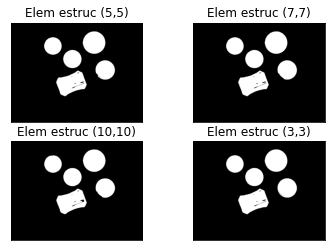

In [14]:
#Testes kernel (Elemento estruturante)

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
kernel3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

opening = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel)
opening1 = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel1)
opening2 = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel2)
opening3 = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel3)

images = [opening,opening1,opening2,opening3]
titles = ['Elem estruc (5,5)','Elem estruc (7,7)', 'Elem estruc (10,10)','Elem estruc (3,3)']


for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()



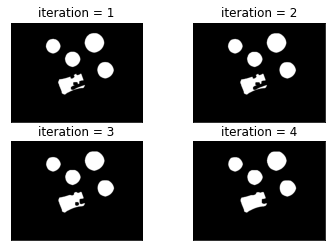

In [15]:
#Testes iterações fecho
closing1 = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE,kernel2,iterations = 1)
closing2 = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE,kernel2,iterations = 2)
closing3 = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE,kernel2,iterations = 3)
closing4 = cv2.morphologyEx(erosion, cv2.MORPH_CLOSE,kernel2,iterations = 4)

images = [closing1,closing2,closing3,closing4]
titles = ['iteration = 1','iteration = 2', 'iteration = 3','iteration = 4']


for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()



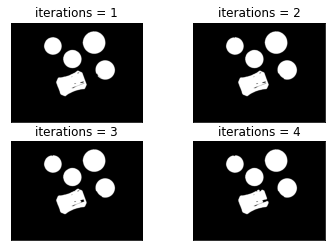

In [16]:
#Testes iterações abertura
opening = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel,iterations=1)
opening1 = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel,iterations=2)
opening2 = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel,iterations=3)
opening3 = cv2.morphologyEx(mascara, cv2.MORPH_OPEN, kernel,iterations=4)


images = [opening,opening1,opening2,opening3]
titles = ['iterations = 1','iterations = 2', 'iterations = 3','iterations = 4']


for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

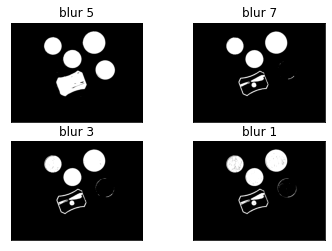

In [17]:
#Testes blur

grayMed1 = cv2.medianBlur(gray,5)
grayMed2 = cv2.medianBlur(gray,3)
grayMed3 = cv2.medianBlur(gray,1)

mask2 = cv2.threshold(grayMed1,127,255,cv2.THRESH_BINARY)
mask2 = mask2[1] 
mask3 = cv2.threshold(grayMed2,127,255,cv2.THRESH_BINARY)
mask3 = mask3[1] 
mask4 = cv2.threshold(grayMed3,127,255,cv2.THRESH_BINARY)
mask4 = mask4[1]
images = [mascara,mask2,mask3,mask4]
titles = ['blur 5','blur 7', 'blur 3','blur 1']


for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


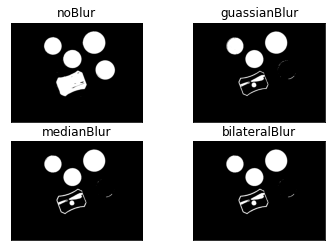

In [18]:
#Testes threshold

grayGuass = cv2.GaussianBlur(gray,(5,5),0)
grayMed = cv2.medianBlur(gray,5)
grayBilateral = cv2.bilateralFilter(gray,9,75,75)

mask2 = cv2.threshold(grayGuass,127,255,cv2.THRESH_BINARY)
mask2 = mask2[1] 
mask3 = cv2.threshold(grayMed,127,255,cv2.THRESH_BINARY)
mask3 = mask3[1] 
mask4 = cv2.threshold(grayMed,127,255,cv2.THRESH_BINARY)
mask4 = mask4[1]
images = [mascara,mask2,mask3,mask4]

titles = ['noBlur','guassianBlur', 'medianBlur','bilateralBlur']


for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()


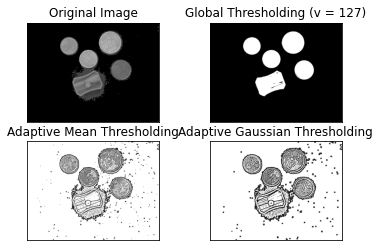

In [19]:
#Testes Criação de Máscara

mask2 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
mask3 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)

images = [gray,mascara,mask2,mask3]

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()
